<a href="https://colab.research.google.com/github/aaron-v-kane/Tareas_EstadisticaAplicada_15/blob/main/AVK_1848627_EstadisticaAplicadaG51_parcial1f.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aar√≥n Villegas Kane

1848627

Estad√≠stica Aplicada G51

# Modelo ETS

## Error Trend Seasonality

## Irregular Tendencia Estacionalidad

Statsmodels proporciona una herramienta de descomposici√≥n estacional que podemos usar para separar los diferentes componentes de una serie de tiempo.

Aplicamos un modelo aditivo cuando parece que la tendencia es m√°s lineal y los componentes de estacionalidad y tendencia parecen ser constantes en el tiempo.

Un modelo multiplicativo es m√°s apropiado cuando estamos aumentando (o disminuyendo) a una tasa no lineal.

Para estos ejemplos, usaremos los datos de las l√≠neas de metro metrorrey, que brinda totales mensuales en miles desde enero de 2007 hasta diciembre de 2021.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
metrorrey = pd.read_csv('metrorrey.csv',index_col='Month',parse_dates=True)

In [3]:
metrorrey.dropna(inplace=True)

In [4]:
metrorrey.head()

Thousands of Passengers
Month                              
2007-01-01                     4788
2007-02-01                     4848
2007-03-01                     5648
2007-04-01                     4816
2007-05-01                     5613

In [5]:
metrorrey.rename(columns = {'Thousands of Passengers': 'miles de pasajeros'}, inplace = True)

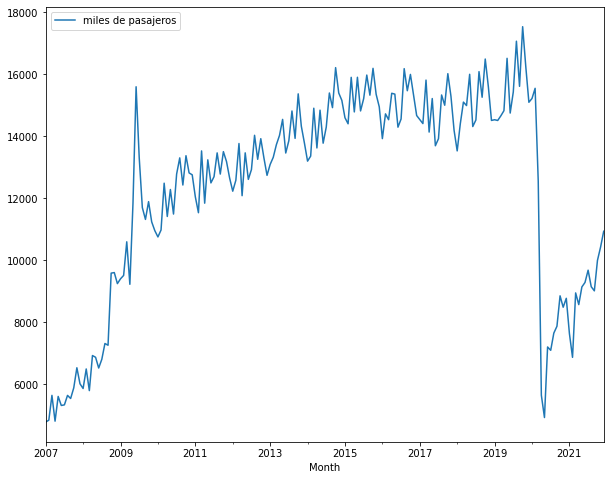

In [6]:
metrorrey.plot(figsize=(10,8));

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


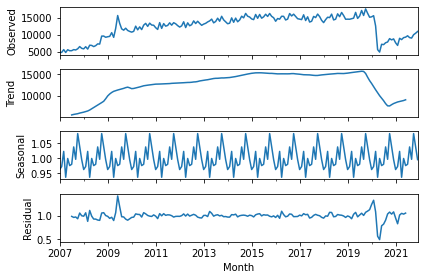

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(metrorrey['miles de pasajeros'], model='multiplicative')  #mul tambien funciona
result.plot();


In [8]:
#vamos a obtner la serie desestacionalida
#primero obtenemos el componente estacional al que accedemos con .seasonal del objeto result
componente_estacional = result.seasonal
metrorrey['desestacionalizado'] = metrorrey['miles de pasajeros'] / componente_estacional

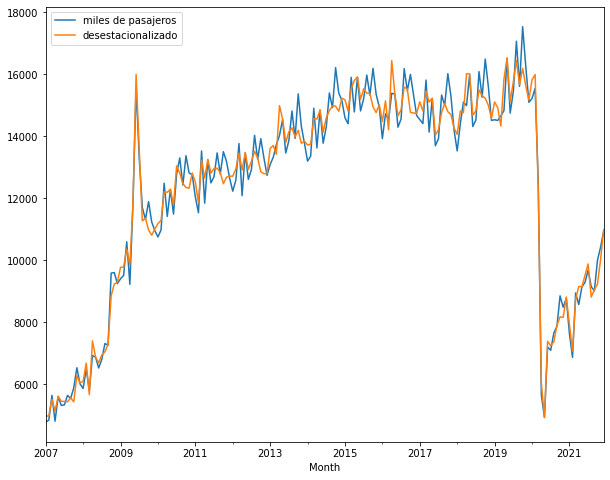

In [9]:
#graficamos
metrorrey[['miles de pasajeros','desestacionalizado']].plot(figsize=(10,8));

# Promedio M√≥vil Simple SMA 
## Simple moving average

In [10]:
metrorrey['PMS-6meses'] = metrorrey['miles de pasajeros'].rolling(window=6).mean()
metrorrey['PMS-12meses'] = metrorrey['miles de pasajeros'].rolling(window=12).mean()

In [11]:
metrorrey.head(15)

miles de pasajeros  desestacionalizado   PMS-6meses  PMS-12meses
Month                                                                       
2007-01-01                4788         4977.267297          NaN          NaN
2007-02-01                4848         4986.629209          NaN          NaN
2007-03-01                5648         5521.054482          NaN          NaN
2007-04-01                4816         5145.501801          NaN          NaN
2007-05-01                5613         5617.267575          NaN          NaN
2007-06-01                5322         5457.113448  5172.500000          NaN
2007-07-01                5341         5451.346422  5264.666667          NaN
2007-08-01                5647         5440.060973  5397.833333          NaN
2007-09-01                5547         5566.856041  5381.000000          NaN
2007-10-01                5890         5438.728104  5560.000000          NaN
2007-11-01                6538         6287.054838  5714.166667          NaN
2007-12-01                6021         6049.614980  5830.666667  5501.583333
2008-01-01                5869         6100.998698  5918.666667  5591.666667
2008-02-01                6499         6684.839776  6060.666667  5729.250000
2008-03-01                5801         5670.615625  6103.000000  5742.000000

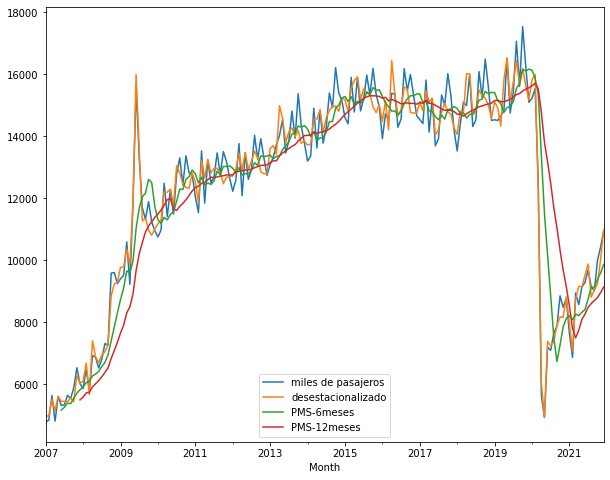

In [12]:
metrorrey.plot(figsize=(10,8));

# Promedio M√≥vil Ponderado Exponencialmente EWMA
## Exponentially Weighted Moving Average

Acabamos de mostrar c√≥mo calcular el PMS para un periodo de tiempo T. Sin embargo, el PMS b√°sico tiene algunas debilidades:
* Periodos de tiempo muy peque√±os generar√°n m√°s ruido, en lugar de  brindarnos una se√±al de la tendencia de la serie
* Siempre tendra un ajuste hacia atr√°s 
* Nunca alcanzar√° el pico o valle completo de los datos debido al promedio.
* Realmente no informa sobre el posible comportamiento futuro de la serie, todo lo que hace es describir la tendencia pasada de los datos.
* Los valores hist√≥ricos extremos pueden sesgar el PMS

Una alternativa que soluciona o minimiza los problemas anteriores es el EWMA

En python  cuando damos adjust true
### $y_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2 x_{t-2} + ...
+ (1 - \alpha)^t x_{0}}{1 + (1 - \alpha) + (1 - \alpha)^2 + ...
+ (1 - \alpha)^t}$

cuando damos adjust False
### $\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

para aplicar EWMA usamos la funci√≥n EWM

In [13]:
metrorrey['EWMA12'] = metrorrey['miles de pasajeros'].ewm(span=12,adjust=False).mean()

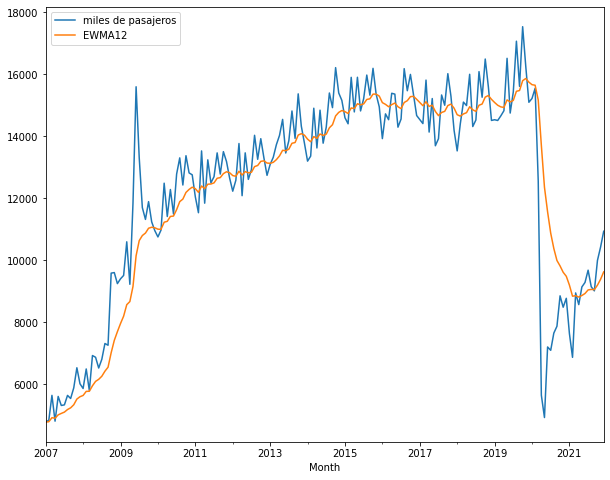

In [14]:
metrorrey[['miles de pasajeros','EWMA12']].plot(figsize=(10,8));

## Comparemos PMS to EWMA

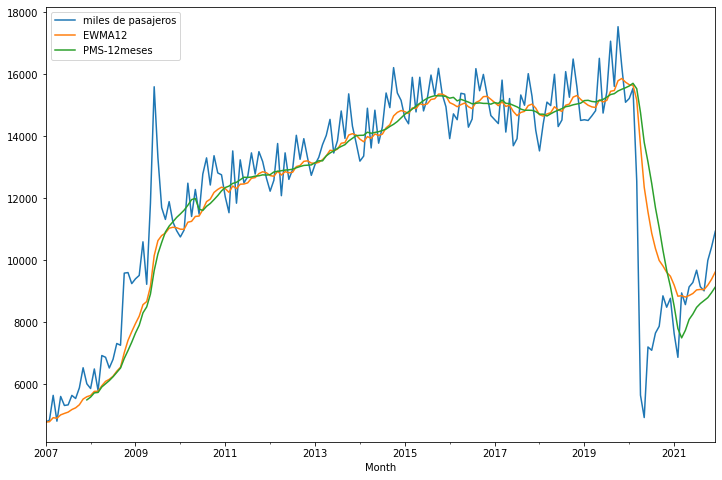

In [15]:
metrorrey[['miles de pasajeros','EWMA12','PMS-12meses']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

# M√©todos Holt-Winters 

En esta secci√≥n, veremos el suavizado exponencial doble y triple con los m√©todos de Holt-Winters.

En el suavizado exponencial doble (tambi√©n conocido como m√©todo de Holt) presentamos un nuevo factor de suavizado ùõΩ (beta) que aborda la tendencia:
\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    nivel}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    tendencia}\\
y_t &= l_t + b_t & \text{   modelo estimado}\\
\hat y_{t+h} &= l_t + hb_t & \text{    modelo de pron√≥stico (} h = \text{# periodos futuros)}\end{split}

Debido a que a√∫n no hemos considerado las fluctuaciones estacionales, el modelo de pron√≥stico es simplemente una l√≠nea recta que se extiende desde el punto de datos m√°s reciente.

Con el suavizado exponencial triple (tambi√©n conocido como el m√©todo Holt-Winters) introducimos un factor de suavizado ùõæ (gamma) que aborda la estacionalidad:
\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    nivel}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    tendencia}\\
c_t &= (1-\gamma)c_{t-L} + \gamma(x_t-l_{t-1}-b_{t-1}) & \text{    estacionalidad}\\
y_t &= (l_t + b_t) c_t & \text{    modelo estimado}\\
\hat y_{t+m} &= (l_t + mb_t)c_{t-L+1+(m-1)modL} & \text{    modelo de pron√≥stico (} m = \text{# periodos futuros)}\end{split}
$L$ representa el n√∫mero de frecuencia de la serie por periodo. En nuestro caso tenemos datos mensuales, por tanto debemos usar $L=12$.

En general, valores muy grandes de $\alpha$, $\beta$ y $\gamma$, dan mas peso a las observaciones presentes.

Antes de ejecutar el m√©todo de holt winters tenemos que establecer la frecuencia de los datos

In [16]:
metrorrey.index

DatetimeIndex(['2007-01-01', '2007-02-01', '2007-03-01', '2007-04-01',
               '2007-05-01', '2007-06-01', '2007-07-01', '2007-08-01',
               '2007-09-01', '2007-10-01',
               ...
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01'],
              dtype='datetime64[ns]', name='Month', length=180, freq=None)

note que en **freq** no esta especificado

In [17]:
metrorrey.index.freq = 'MS'
metrorrey.index

DatetimeIndex(['2007-01-01', '2007-02-01', '2007-03-01', '2007-04-01',
               '2007-05-01', '2007-06-01', '2007-07-01', '2007-08-01',
               '2007-09-01', '2007-10-01',
               ...
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01'],
              dtype='datetime64[ns]', name='Month', length=180, freq='MS')

## Promedio exponencial simple

La funci√≥n statmodels Holt-Winters nos permite hacer el suavizamiento exponencial simple. es el equivalente al que usamos con pandas  <tt>.ewm()</tt> 

$\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

In [18]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 12
alpha = 2/(span+1)


metrorrey['SES12']=SimpleExpSmoothing(metrorrey['miles de pasajeros']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
metrorrey.head()

miles de pasajeros  desestacionalizado  PMS-6meses  PMS-12meses  \
Month                                                                         
2007-01-01                4788         4977.267297         NaN          NaN   
2007-02-01                4848         4986.629209         NaN          NaN   
2007-03-01                5648         5521.054482         NaN          NaN   
2007-04-01                4816         5145.501801         NaN          NaN   
2007-05-01                5613         5617.267575         NaN          NaN   

                 EWMA12        SES12  
Month                                 
2007-01-01  4788.000000  4788.000000  
2007-02-01  4797.230769  4797.230769  
2007-03-01  4928.118343  4928.118343  
2007-04-01  4910.869367  4910.869367  
2007-05-01  5018.889465  5018.889465

## Double Exponential Smoothing
Donde el suavizado exponencial simple emplea solo un factor de suavizado $\alpha$ (alfa), el suavizado exponencial doble agrega un segundo factor de suavizado $\beta$ (beta) que aborda las tendencias en los datos. Al igual que el factor alfa, los valores del factor beta se encuentran entre cero y uno ($0<\beta‚â§1$). La ventaja es  que ahora el modelo puede anticipar futuros aumentos o disminuciones.

Tambi√©n podemos abordar diferentes tipos de cambio (crecimiento/decadencia) en la tendencia. Si una serie de tiempo muestra una tendencia inclinada en l√≠nea recta, usar√≠a un ajuste <strong>aditivo</strong>. Si la serie temporal muestra una tendencia exponencial (curva), usar√≠a un ajuste <strong>multiplicativo</strong>.

A medida que avanzamos hacia el pron√≥stico, vale la pena se√±alar que tanto los ajustes aditivos como los multiplicativos pueden exagerarse con el tiempo y requieren <em>amortiguaci√≥n</em> que reduce el tama√±o de la tendencia en per√≠odos futuros hasta que alcanza una l√≠nea plana.

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

metrorrey['DESadd12'] = ExponentialSmoothing(metrorrey['miles de pasajeros'], trend='add').fit().fittedvalues.shift(-1)
metrorrey.head()

miles de pasajeros  desestacionalizado  PMS-6meses  PMS-12meses  \
Month                                                                         
2007-01-01                4788         4977.267297         NaN          NaN   
2007-02-01                4848         4986.629209         NaN          NaN   
2007-03-01                5648         5521.054482         NaN          NaN   
2007-04-01                4816         5145.501801         NaN          NaN   
2007-05-01                5613         5617.267575         NaN          NaN   

                 EWMA12        SES12     DESadd12  
Month                                              
2007-01-01  4788.000000  4788.000000  4822.264112  
2007-02-01  4797.230769  4797.230769  4876.449750  
2007-03-01  4928.118343  4928.118343  5522.702843  
2007-04-01  4910.869367  4910.869367  4995.439320  
2007-05-01  5018.889465  5018.889465  5519.447231

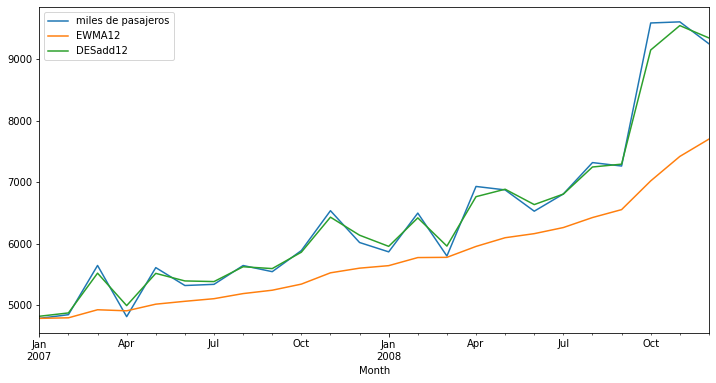

In [20]:
metrorrey[['miles de pasajeros','EWMA12','DESadd12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

podemos ver que el suavizado exponencial doble es una representaci√≥n mejor de los datos de la serie temporal.

Esto es as√≠ por que estamos modelando todos los componentes de la serie

Veamos si usar un ajuste estacional multiplicativo ayuda.

In [21]:
metrorrey['DESmul12'] = ExponentialSmoothing(metrorrey['miles de pasajeros'], trend='mul').fit().fittedvalues.shift(-1)
metrorrey.head()

miles de pasajeros  desestacionalizado  PMS-6meses  PMS-12meses  \
Month                                                                         
2007-01-01                4788         4977.267297         NaN          NaN   
2007-02-01                4848         4986.629209         NaN          NaN   
2007-03-01                5648         5521.054482         NaN          NaN   
2007-04-01                4816         5145.501801         NaN          NaN   
2007-05-01                5613         5617.267575         NaN          NaN   

                 EWMA12        SES12     DESadd12     DESmul12  
Month                                                           
2007-01-01  4788.000000  4788.000000  4822.264112  4783.028549  
2007-02-01  4797.230769  4797.230769  4876.449750  4831.067639  
2007-03-01  4928.118343  4928.118343  5522.702843  5477.484019  
2007-04-01  4910.869367  4910.869367  4995.439320  4946.874155  
2007-05-01  5018.889465  5018.889465  5519.447231  5473.189236

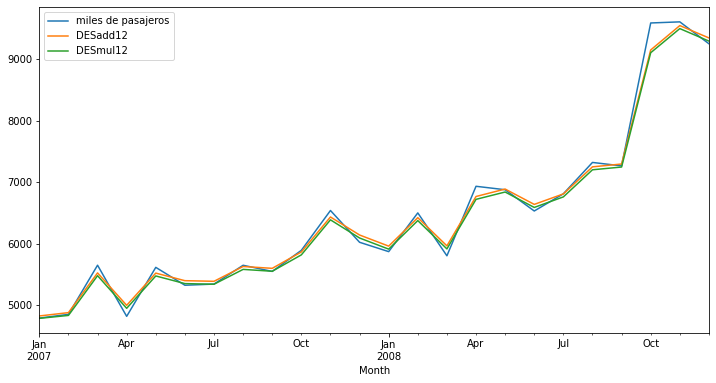

In [22]:
metrorrey[['miles de pasajeros','DESadd12','DESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

## Triple Exponential Smoothing
El suavizado exponencial triple es el m√©todo m√°s estrechamente asociado con Holt-Winters, agrega compatibilidad con las tendencias y la estacionalidad de los datos.

In [23]:
metrorrey['TESadd12'] = ExponentialSmoothing(metrorrey['miles de pasajeros'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
metrorrey.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


miles de pasajeros  desestacionalizado  PMS-6meses  PMS-12meses  \
Month                                                                         
2007-01-01                4788         4977.267297         NaN          NaN   
2007-02-01                4848         4986.629209         NaN          NaN   
2007-03-01                5648         5521.054482         NaN          NaN   
2007-04-01                4816         5145.501801         NaN          NaN   
2007-05-01                5613         5617.267575         NaN          NaN   

                 EWMA12        SES12     DESadd12     DESmul12     TESadd12  
Month                                                                        
2007-01-01  4788.000000  4788.000000  4822.264112  4783.028549  5235.469528  
2007-02-01  4797.230769  4797.230769  4876.449750  4831.067639  4891.397831  
2007-03-01  4928.118343  4928.118343  5522.702843  5477.484019  5560.506494  
2007-04-01  4910.869367  4910.869367  4995.439320  4946.874155  4809.549106  
2007-05-01  5018.889465  5018.889465  5519.447231  5473.189236  5837.580231

In [24]:
metrorrey['TESmul12'] = ExponentialSmoothing(metrorrey['miles de pasajeros'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
metrorrey.head()

miles de pasajeros  desestacionalizado  PMS-6meses  PMS-12meses  \
Month                                                                         
2007-01-01                4788         4977.267297         NaN          NaN   
2007-02-01                4848         4986.629209         NaN          NaN   
2007-03-01                5648         5521.054482         NaN          NaN   
2007-04-01                4816         5145.501801         NaN          NaN   
2007-05-01                5613         5617.267575         NaN          NaN   

                 EWMA12        SES12     DESadd12     DESmul12     TESadd12  \
Month                                                                         
2007-01-01  4788.000000  4788.000000  4822.264112  4783.028549  5235.469528   
2007-02-01  4797.230769  4797.230769  4876.449750  4831.067639  4891.397831   
2007-03-01  4928.118343  4928.118343  5522.702843  5477.484019  5560.506494   
2007-04-01  4910.869367  4910.869367  4995.439320  4946.874155  4809.549106   
2007-05-01  5018.889465  5018.889465  5519.447231  5473.189236  5837.580231   

               TESmul12  
Month                    
2007-01-01  5352.591587  
2007-02-01  5022.016813  
2007-03-01  5377.496002  
2007-04-01  4871.168739  
2007-05-01  5375.194106

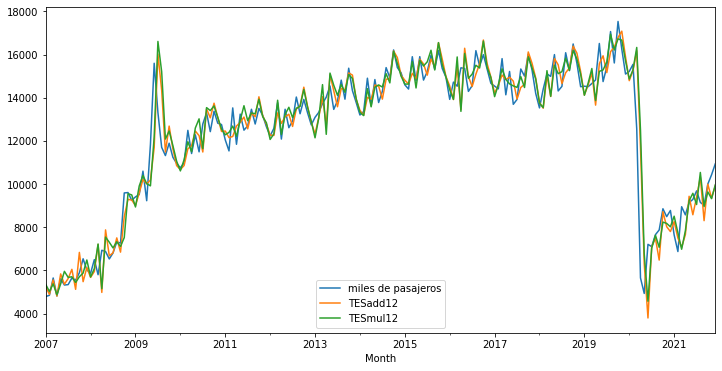

In [25]:
metrorrey[['miles de pasajeros','TESadd12','TESmul12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

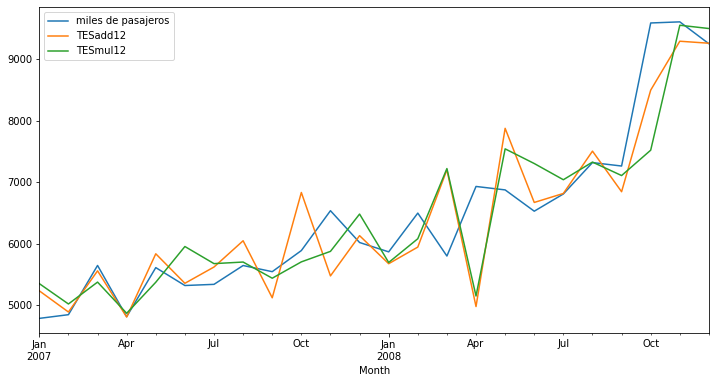

In [26]:
metrorrey[['miles de pasajeros','TESadd12','TESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

Seg√∫n el gr√°fico anterior, podr√≠a pensarse que el suavizado exponencial triple hace un trabajo de ajuste peor que el suavizado exponencial doble. La clave aqu√≠ es considerar lo que viene a continuaci√≥n: el pron√≥stico. Veremos que tener la capacidad de predecir patrones estacionales fluctuantes mejora enormemente nuestro pron√≥stico.

## pron√≥stico

In [27]:
#volvemos a estimar los modelos, pero guardandolos en un objeto
modelo_DESadd12 = ExponentialSmoothing(metrorrey['miles de pasajeros'], trend='add').fit()
modelo_TESmul12 = ExponentialSmoothing(metrorrey['miles de pasajeros'],trend='mul',seasonal='mul',seasonal_periods=12).fit()


una vez guardados, hacemos el pron√≥stico


In [28]:
pronostico_DESadd12 = modelo_DESadd12.forecast(36).rename('predicci√≥n DES')
pronostico_TESmul12 = modelo_TESmul12.forecast(36).rename('predicci√≥n TES')


ahora graficamos


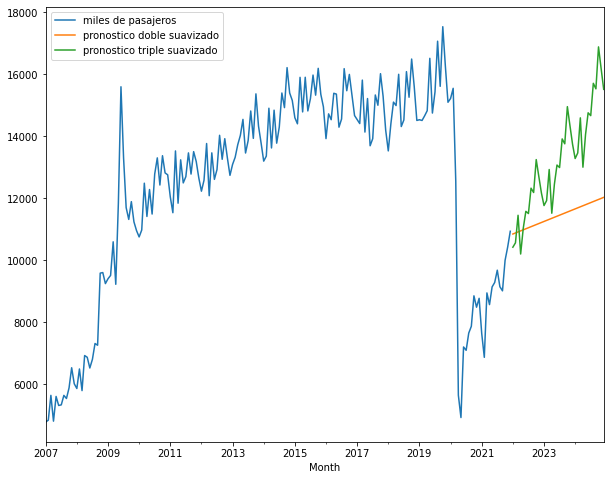

In [29]:
metrorrey['miles de pasajeros'].plot(figsize=(10,8));
pronostico_DESadd12.plot(label ='pronostico doble suavizado');
pronostico_TESmul12.plot(label ='pronostico triple suavizado');
plt.legend(loc = 'upper left')


Obviamente como el modelo de doble suavizamiento exponencial (DES) solo contempla la tendencia, el pron√≥stico es la tendencia

el modelo de triple suavizado exponencial (TES) considera el factor estacional, pron√≥stica considerando el efecto estacional